<a id='1'></a>
## _Import Libraries and Load Data_

In [1]:
#general packages for data manipulation
import os
import pandas as pd
import numpy as np
#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent sized plot 
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
#handle the warnings in the code
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#text preprocessing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
#import texthero
#import texthero as hero
#regular expressions
import re
#display pandas dataframe columns 
pd.options.display.max_columns = None

In [2]:
#load the csv file as a pandas dataframe
#tweet = pd.read_csv('../input/datensatz-target/Datensatz_target - Tabellenblatt1.csv',delimiter=',',engine='python',encoding='utf-8-sig')

#load modified
tweet = pd.read_csv('/kaggle/input/data-modified/to_annotate - to_annotate.tsv', sep = '\t')
tweet = tweet.drop('Status', axis=1)
tweet = tweet.drop('hatespeech', axis=1)
tweet = tweet.drop('toxi', axis=1)

tweet.head()

,c_text,target
0,@Laika66753508 @MartinaWeiss48 @reitschuster M...,person
1,@manaf12hassan Die Karte muss in Gesicht von F...,person
2,@Tino_Chrupalla @Karl_Lauterbach Wenn Sie kack...,group
3,@DemokratDer @manuelak62 666,public
4,"@_agronym Junge was für Verfolgung, die befeue...",person


In [3]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38142 entries, 0 to 38141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c_text  38142 non-null  object
 1   target  10090 non-null  object
dtypes: object(2)
memory usage: 596.1+ KB


In [4]:
#Prüfung auf NaN im Datensatz
tweet.isnull().sum() #771 Datensätze haben ein NaN in ['target']

#Entfernen der NaN aus Datensatz
tweet = tweet.dropna()
tweet.isnull().sum() #0 Datensätze haben ein NaN in ['target']

c_text    0
target    0
dtype: int64

In [5]:
tweet['target'] =tweet['target'].map(lambda x: x.lower())
tweet['target'].value_counts()

person     4609
group      3502
public     1970
puplic        3
target        2
peson         1
pweaon        1
person        1
perosn        1
Name: target, dtype: int64

In [6]:
tweet = tweet[tweet['target'] != 'target']
tweet = tweet[tweet['target'] != 'peson']
tweet = tweet[tweet['target'] != 'pweaon']
tweet = tweet[tweet['target'] != 'perosn']
tweet = tweet[tweet['target'] != 'puplic']
tweet = tweet[tweet['target'] != 'person ']
tweet['target'].value_counts()

person    4609
group     3502
public    1970
Name: target, dtype: int64

In [7]:
#view one of the tweets randomly 
random = np.random.randint(0,len(tweet))
print(random)
tweet.iloc[random]['c_text']

3654


'@DanieleUlrich @CR_Schmid @joergscheller1 @LeaKusano Und noch eine Prise Rassismus durch einen Zwangsmassnahmen-Befürworter. Direkt von einem Account eines grossen Staatsbetriebs. Allerliebst.'

In [8]:
#create a copy of the original data to work with 
df = tweet.copy()

<a id='2'></a>
## _Text Cleaning_

<a id='2-2'></a>
### _Remove user handles_

In [9]:
#test on a sample string
sample = "and @user1 i would like you to discuss with @user2 and then with @username3"
pattern = re.compile(r'@\w+')
re.findall(pattern,sample)

['@user1', '@user2', '@username3']

In [10]:
#remove all the user handles --> strings starting with @
df['c_text'].replace(r'@\w+','',regex=True,inplace=True)
df['c_text'].head()

0       Meine Liebe.. Sie bilden sich anscheinend a...
1     Die Karte muss in Gesicht von Frau Merkel und...
2      Wenn Sie kackbraune Scheiße blau übermalen w...
3                                                  666
4     Junge was für Verfolgung, die befeuern aus ih...
Name: c_text, dtype: object

<a id='2-3'></a>
### _Remove the urls_

In [11]:
#test on a sample 
sample = "https://www.machinelearing.com prakhar and https://www.simple.com"
pattern = re.compile(r'http\S+')
re.findall(pattern,sample)

['https://www.machinelearing.com', 'https://www.simple.com']

In [12]:
df['c_text'].replace(r'http\S+','',regex=True,inplace=True)
df['c_text'].head()

0       Meine Liebe.. Sie bilden sich anscheinend a...
1     Die Karte muss in Gesicht von Frau Merkel und...
2      Wenn Sie kackbraune Scheiße blau übermalen w...
3                                                  666
4     Junge was für Verfolgung, die befeuern aus ih...
Name: c_text, dtype: object

<a id='2-4'></a>
### _Tokenize using tweet tokenizer_

In [13]:
#test on a sample text
sample = 'wonderfl :-)  when are you coming for #party'
tweet_tokenize = TweetTokenizer(preserve_case=True)
tweet_tokenize.tokenize(sample)

['wonderfl', ':-)', 'when', 'are', 'you', 'coming', 'for', '#party']

In [14]:
#tokenize the tweets in the dataframe using TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=True)
df['c_text_tokens'] = df['c_text'].apply(tokenizer.tokenize)

In [15]:
#view the tokenized tweets
df.head(3)

,c_text,target,c_text_tokens
0,Meine Liebe.. Sie bilden sich anscheinend a...,person,"[Meine, Liebe, .., Sie, bilden, sich, anschein..."
1,Die Karte muss in Gesicht von Frau Merkel und...,person,"[Die, Karte, muss, in, Gesicht, von, Frau, Mer..."
2,Wenn Sie kackbraune Scheiße blau übermalen w...,group,"[Wenn, Sie, kackbraune, Scheiße, blau, übermal..."


<a id='2-5'></a>
### _Remove Stopwords_
_Append more words to be removed from the text - example rt and amp which occur very frequently_

In [16]:
stop_words = stopwords.words('german')

#add additional stop words to be removed from the text
additional_list = ['Die', 'Das', 'Und', 'mal', 'ja', 'schon', 'mehr', 'immer', 'Aber', 'Wenn']
#Die, Das, Und, mal, ja, schon, mehr

for words in additional_list:
    stop_words.append(words)

In [17]:
stop_words[-10:]

['Die', 'Das', 'Und', 'mal', 'ja', 'schon', 'mehr', 'immer', 'Aber', 'Wenn']

In [18]:
#remove stop words
def remove_stopwords(text):
    '''Function to remove the stop words from the text corpus'''
    clean_text = [word for word in text if not word in stop_words]
    return clean_text    

In [19]:
#remove the stop words from the tweets
df['c_text_tokens'] = df['c_text_tokens'].apply(remove_stopwords)

In [20]:
df['c_text_tokens'].head()

0      [Meine, Liebe, .., Sie, bilden, anscheinend, 🧐]
1    [Karte, Gesicht, Frau, Merkel, Herr, spahn, ho...
2    [Sie, kackbraune, Scheiße, blau, übermalen, kl...
3                                                [666]
4    [Junge, Verfolgung, ,, befeuern, Eigentumswohn...
Name: c_text_tokens, dtype: object

<a id='2-6'></a>
### _Spelling corrections_

<a id='2-7'></a>
### _Remove # symbols while retaining the text_

In [21]:
#try tremoving # symbols from a sample text
sample = '#winner #machine i am learning'
pattern = re.compile(r'#')
re.sub(pattern,'',sample)

'winner machine i am learning'

In [22]:
def remove_hashsymbols(text):
    '''Function to remove the hashtag symbol from the text'''
    pattern = re.compile(r'#')
    text = ' '.join(text)
    clean_text = re.sub(pattern,'',text)
    return tokenizer.tokenize(clean_text)    

In [23]:
df['c_text_tokens'] = df['c_text_tokens'].apply(remove_hashsymbols)

In [24]:
df.head(3)

,c_text,target,c_text_tokens
0,Meine Liebe.. Sie bilden sich anscheinend a...,person,"[Meine, Liebe, .., Sie, bilden, anscheinend, 🧐]"
1,Die Karte muss in Gesicht von Frau Merkel und...,person,"[Karte, Gesicht, Frau, Merkel, Herr, spahn, ho..."
2,Wenn Sie kackbraune Scheiße blau übermalen w...,group,"[Sie, kackbraune, Scheiße, blau, übermalen, kl..."


<a id='2-9'></a>
### _Remove digits_

In [25]:
def rem_digits(text):
    '''Function to remove the digits from the list of strings'''
    no_digits = []
    for word in text:
        no_digits.append(re.sub(r'\d','',word))
    return ' '.join(no_digits)   

In [26]:
df['c_text_tokens'] = df['c_text_tokens'].apply(rem_digits)

In [27]:
df['c_text_tokens'] = df['c_text_tokens'].apply(tokenizer.tokenize)

In [28]:
df.head()

,c_text,target,c_text_tokens
0,Meine Liebe.. Sie bilden sich anscheinend a...,person,"[Meine, Liebe, .., Sie, bilden, anscheinend, 🧐]"
1,Die Karte muss in Gesicht von Frau Merkel und...,person,"[Karte, Gesicht, Frau, Merkel, Herr, spahn, ho..."
2,Wenn Sie kackbraune Scheiße blau übermalen w...,group,"[Sie, kackbraune, Scheiße, blau, übermalen, kl..."
3,666,public,[]
4,"Junge was für Verfolgung, die befeuern aus ih...",person,"[Junge, Verfolgung, ,, befeuern, Eigentumswohn..."


### Remove Emojis

In [29]:
emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F" # emoticons
        u"\U0001F300-\U0001F5FF" # symbols & pictographs
        u"\U0001F680-\U0001F6FF" # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" # flags (iOS)
        u"\U00002500-\U00002BEF" # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" # dingbats
        u"\u3030"
        "]+", 
        flags=re.UNICODE,
    )

def rem_emojis(text):
    '''Function to remove the emojis from the list of strings'''
    no_emojis = []
    for word in text:
        no_emojis.append(re.sub(emoji_pattern,'',word))
    return ' '.join(no_emojis)   

In [30]:
df['c_text_tokens'] = df['c_text_tokens'].apply(rem_emojis)

In [31]:
df['c_text_tokens'] = df['c_text_tokens'].apply(tokenizer.tokenize)

In [32]:
df.head()

,c_text,target,c_text_tokens
0,Meine Liebe.. Sie bilden sich anscheinend a...,person,"[Meine, Liebe, .., Sie, bilden, anscheinend]"
1,Die Karte muss in Gesicht von Frau Merkel und...,person,"[Karte, Gesicht, Frau, Merkel, Herr, spahn, ho..."
2,Wenn Sie kackbraune Scheiße blau übermalen w...,group,"[Sie, kackbraune, Scheiße, blau, übermalen, kl..."
3,666,public,[]
4,"Junge was für Verfolgung, die befeuern aus ih...",person,"[Junge, Verfolgung, ,, befeuern, Eigentumswohn..."


### Remove Punctuation

In [33]:

def rem_punctuation(text):
    '''Function to remove the punctuation from the list of strings'''
    no_punc = []
    for word in text:
        no_punc.append(re.sub(r'[^\w\s]','',word))
    return ' '.join(no_punc)   

In [34]:
df['c_text_tokens'] = df['c_text_tokens'].apply(rem_punctuation)

In [35]:
df['c_text_tokens'] = df['c_text_tokens'].apply(tokenizer.tokenize)

In [36]:
df.head()

,c_text,target,c_text_tokens
0,Meine Liebe.. Sie bilden sich anscheinend a...,person,"[Meine, Liebe, Sie, bilden, anscheinend]"
1,Die Karte muss in Gesicht von Frau Merkel und...,person,"[Karte, Gesicht, Frau, Merkel, Herr, spahn, ho..."
2,Wenn Sie kackbraune Scheiße blau übermalen w...,group,"[Sie, kackbraune, Scheiße, blau, übermalen, kl..."
3,666,public,[]
4,"Junge was für Verfolgung, die befeuern aus ih...",person,"[Junge, Verfolgung, befeuern, Eigentumswohnung..."


<a id='3'></a>
## _Exploratory Data Analysis - Broad Approach_

<a id='3-1'></a>
### _Check for data balance_

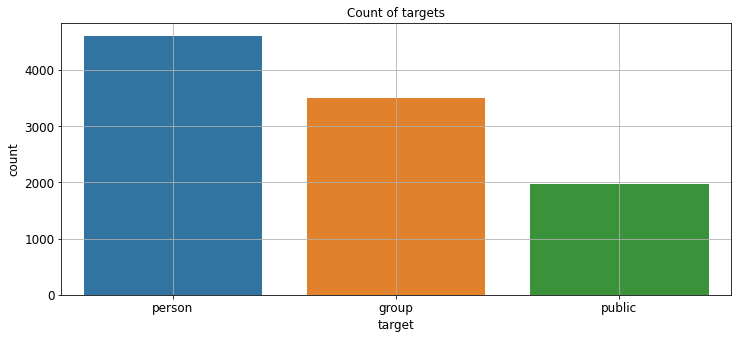

In [37]:
#plot of the count of hate and non hate tweet
sns.countplot(df['target'])
plt.title('Count of targets')
plt.grid()
plt.show()

In [38]:
df['target'].value_counts()

person    4609
group     3502
public    1970
Name: target, dtype: int64

<a id='3-2'></a>
### _Check out the top terms in the tweets_

In [39]:
from collections import Counter
results = Counter()
df['c_text_tokens'].apply(results.update)
#print the top 10 most common terms in the tweet 
print(results.most_common(10))

[('Sie', 2095), ('Ich', 1436), ('Du', 681), ('Es', 533), ('Querdenker', 528), ('Was', 459), ('Menschen', 458), ('AfD', 400), ('einfach', 398), ('Der', 396)]


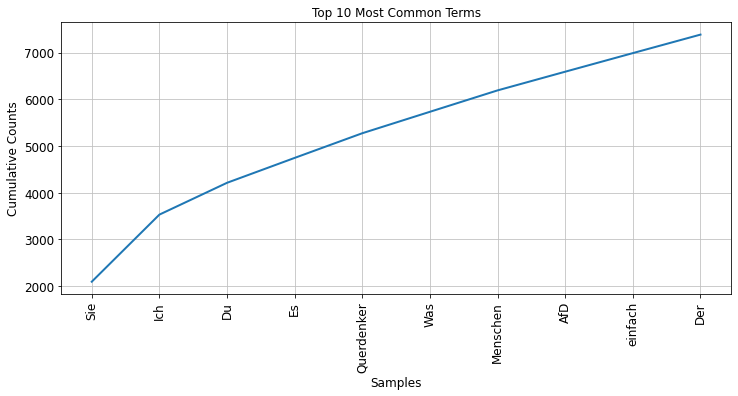

In [40]:
#plot the cumulative frequency of the top 10 most common tokens 
frequency = nltk.FreqDist(results)
plt.title('Top 10 Most Common Terms')
frequency.plot(10,cumulative=True)
plt.show()

Die, Das, Und, mal, ja, schon, mehr

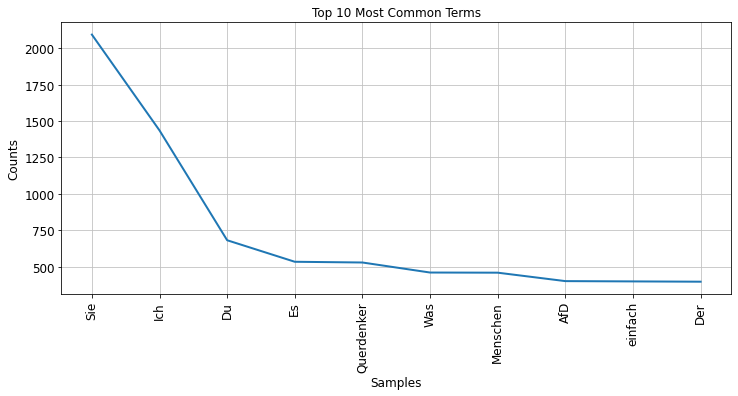

In [41]:
#plot the frequency of the top 10 most common tokens 
frequency = nltk.FreqDist(results)
plt.title('Top 10 Most Common Terms')
frequency.plot(10,cumulative=False)
plt.show()

_Love is the most frequently used word followed by day, happy etc. This is expected as there are more non hate tweets than hate tweets in the dataset_

<a id='4'></a>
## _Predictive Modeling_

### _Data Formatting for Predictive Modeling_

In [42]:
df.head()

,c_text,target,c_text_tokens
0,Meine Liebe.. Sie bilden sich anscheinend a...,person,"[Meine, Liebe, Sie, bilden, anscheinend]"
1,Die Karte muss in Gesicht von Frau Merkel und...,person,"[Karte, Gesicht, Frau, Merkel, Herr, spahn, ho..."
2,Wenn Sie kackbraune Scheiße blau übermalen w...,group,"[Sie, kackbraune, Scheiße, blau, übermalen, kl..."
3,666,public,[]
4,"Junge was für Verfolgung, die befeuern aus ih...",person,"[Junge, Verfolgung, befeuern, Eigentumswohnung..."


In [43]:
#check for the null values
df.isnull().sum()

c_text           0
target           0
c_text_tokens    0
dtype: int64

In [44]:
#join the tokens back to form the string
df['tweet'] = df['c_text_tokens'].apply(lambda x: ' '.join(x))

In [45]:
#check the top rows
df.head(3)

,c_text,target,c_text_tokens,tweet
0,Meine Liebe.. Sie bilden sich anscheinend a...,person,"[Meine, Liebe, Sie, bilden, anscheinend]",Meine Liebe Sie bilden anscheinend
1,Die Karte muss in Gesicht von Frau Merkel und...,person,"[Karte, Gesicht, Frau, Merkel, Herr, spahn, ho...",Karte Gesicht Frau Merkel Herr spahn hoch gezogen
2,Wenn Sie kackbraune Scheiße blau übermalen w...,group,"[Sie, kackbraune, Scheiße, blau, übermalen, kl...",Sie kackbraune Scheiße blau übermalen kleine A...


In [46]:
#split the data into input X and output y
X = df['tweet']
y = df['target']

In [47]:
#split the data 
from sklearn.model_selection import train_test_split
seed = 51
test_size = 0.2 #20% of the data in the 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed,stratify=df['target'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(8064,) (2017,) (8064,) (2017,)


<a id='4-2'></a>
### _Use tf-idf as a feature to get into the vector space model_


In [48]:
#import tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [49]:
#instantiate the vectorizer 
vectorizer = TfidfVectorizer(max_features=5000)

In [50]:
#fit on the training data
X_train = vectorizer.fit_transform(X_train)
#transform the test data
X_test = vectorizer.transform(X_test)

In [51]:
#check the shape
X_train.shape, X_test.shape

((8064, 5000), (2017, 5000))

In [52]:
#RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(sampling_strategy='minority')
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {y_res}")
print(f"Testing target statistics: {y_test}")

Training target statistics: 0        public
1        person
2        person
3        public
4        public
          ...  
10170    public
10171    public
10172    public
10173    public
10174    public
Name: target, Length: 10175, dtype: object
Testing target statistics: 3434     public
26889    person
4922      group
2312     public
27130    person
          ...  
7698     person
21890     group
4458     person
7696      group
3319      group
Name: target, Length: 2017, dtype: object


In [53]:
X_res.shape, y_res.shape


((10175, 5000), (10175,))

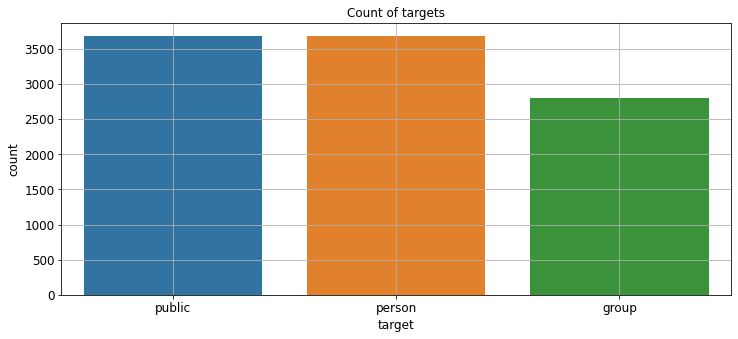

In [54]:
#plot of the count of hate and non hate tweet
sns.countplot(y_res)
plt.title('Count of targets')
plt.grid()
plt.show()

In [55]:
X_train = X_res
y_train = y_res

<a id='4-3'></a>
### _Model building: Ordinary Logistic Regression_

In [56]:
import time

In [57]:
#import the models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [58]:
#instantiate the models with default hyper-parameters
start= time.time()

clf_LR = LogisticRegression()
clf_LR.fit(X_train,y_train)
LR_train_predictions = clf_LR.predict(X_train)
LR_test_predictions = clf_LR.predict(X_test)

time_NB= time.time()-start
print('It took',time_NB, 'seconds.')

It took 1.6487939357757568 seconds.


<a id='4-4'></a>
### _Model evaluation_



In [59]:
#import the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [60]:
#get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,LR_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,LR_test_predictions))

Accuracy Score on training set 0.85710
Accuracy Score on test set 0.65047


_Accuracy is never a good metric for an imbalanced dataset as in this case. This can be highighted using the f1 score. A low f1-score for a label indicate poor performance of the model._

In [61]:
print('Classification Report Training set')
print('\n')
print(classification_report(y_train,LR_train_predictions))

Classification Report Training set


              precision    recall  f1-score   support

       group       0.88      0.78      0.82      2801
      person       0.88      0.84      0.86      3687
      public       0.83      0.93      0.88      3687

    accuracy                           0.86     10175
   macro avg       0.86      0.85      0.85     10175
weighted avg       0.86      0.86      0.86     10175



In [62]:
print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,LR_test_predictions))

Classification Report Testing set


              precision    recall  f1-score   support

       group       0.72      0.59      0.65       701
      person       0.76      0.70      0.73       922
      public       0.42      0.63      0.51       394

    accuracy                           0.65      2017
   macro avg       0.63      0.64      0.63      2017
weighted avg       0.68      0.65      0.66      2017



_The model's f1-score is low for label 1 which indicates the hate text in the twitter_

### _Model building: SVM_

In [63]:
#import the models
from sklearn.svm import SVC


In [64]:
#instantiate the models with default hyper-parameters
start= time.time()


svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train,y_train)
SVM_train_predictions = svclassifier.predict(X_train)
SVM_test_predictions = svclassifier.predict(X_test)

time_NB= time.time()-start
print('It took',time_NB, 'seconds.')

It took 21.414706230163574 seconds.


<a id='4-4'></a>
### _Model evaluation_



In [65]:
#import the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [66]:
#get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,SVM_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,SVM_test_predictions))

Accuracy Score on training set 0.87843
Accuracy Score on test set 0.65146


_Accuracy is never a good metric for an imbalanced dataset as in this case. This can be highighted using the f1 score. A low f1-score for a label indicate poor performance of the model._

In [67]:
print('Classification Report Training set')
print('\n')
print(classification_report(y_train,SVM_train_predictions))

Classification Report Training set


              precision    recall  f1-score   support

       group       0.89      0.82      0.86      2801
      person       0.90      0.86      0.88      3687
      public       0.85      0.94      0.90      3687

    accuracy                           0.88     10175
   macro avg       0.88      0.87      0.88     10175
weighted avg       0.88      0.88      0.88     10175



In [68]:
print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,SVM_test_predictions))

Classification Report Testing set


              precision    recall  f1-score   support

       group       0.70      0.61      0.65       701
      person       0.75      0.70      0.73       922
      public       0.44      0.61      0.51       394

    accuracy                           0.65      2017
   macro avg       0.63      0.64      0.63      2017
weighted avg       0.67      0.65      0.66      2017



### _Model building: NaiveBayes_

In [69]:
#import the models
from sklearn.naive_bayes import MultinomialNB

In [70]:
#instantiate the models with default hyper-parameters

start= time.time()

nbclassifier = MultinomialNB()
nbclassifier.fit(X_train,y_train)
NB_train_predictions = nbclassifier.predict(X_train)
NB_test_predictions = nbclassifier.predict(X_test)

time_NB= time.time()-start
print('It took',time_NB, 'seconds.')

It took 0.04121255874633789 seconds.


<a id='4-4'></a>
### _Model evaluation_



In [71]:
#import the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [72]:
#get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,NB_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,NB_test_predictions))

Accuracy Score on training set 0.81032
Accuracy Score on test set 0.64403


_Accuracy is never a good metric for an imbalanced dataset as in this case. This can be highighted using the f1 score. A low f1-score for a label indicate poor performance of the model._

In [73]:
print('Classification Report Training set')
print('\n')
print(classification_report(y_train,NB_train_predictions))

Classification Report Training set


              precision    recall  f1-score   support

       group       0.87      0.71      0.78      2801
      person       0.79      0.84      0.82      3687
      public       0.79      0.85      0.82      3687

    accuracy                           0.81     10175
   macro avg       0.82      0.80      0.81     10175
weighted avg       0.81      0.81      0.81     10175



In [74]:
print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,NB_test_predictions))

Classification Report Testing set


              precision    recall  f1-score   support

       group       0.73      0.57      0.64       701
      person       0.73      0.75      0.74       922
      public       0.40      0.54      0.46       394

    accuracy                           0.64      2017
   macro avg       0.62      0.62      0.61      2017
weighted avg       0.66      0.64      0.65      2017



### _Model building: RandomForest_

In [75]:
#import the models
from sklearn.ensemble import RandomForestClassifier

In [76]:
#instantiate the models with default hyper-parameters

start= time.time()

rfclassifier = RandomForestClassifier()
rfclassifier.fit(X_train,y_train)
RF_train_predictions = rfclassifier.predict(X_train)
RF_test_predictions = rfclassifier.predict(X_test)

time_NB= time.time()-start
print('It took',time_NB, 'seconds.')

It took 13.615705728530884 seconds.


<a id='4-4'></a>
### _Model evaluation_



In [77]:
#import the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [78]:
#get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,RF_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,RF_test_predictions))

Accuracy Score on training set 0.99420
Accuracy Score on test set 0.64204


_Accuracy is never a good metric for an imbalanced dataset as in this case. This can be highighted using the f1 score. A low f1-score for a label indicate poor performance of the model._

In [79]:
print('Classification Report Training set')
print('\n')
print(classification_report(y_train,RF_train_predictions))

Classification Report Training set


              precision    recall  f1-score   support

       group       1.00      0.99      1.00      2801
      person       1.00      0.99      0.99      3687
      public       0.99      1.00      0.99      3687

    accuracy                           0.99     10175
   macro avg       0.99      0.99      0.99     10175
weighted avg       0.99      0.99      0.99     10175



In [80]:
print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,RF_test_predictions))

Classification Report Testing set


              precision    recall  f1-score   support

       group       0.71      0.60      0.65       701
      person       0.73      0.70      0.71       922
      public       0.43      0.59      0.50       394

    accuracy                           0.64      2017
   macro avg       0.62      0.63      0.62      2017
weighted avg       0.66      0.64      0.65      2017



### _Model building: DecisionTree_

In [81]:
#import the models
from sklearn.tree import DecisionTreeClassifier

In [82]:
#instantiate the models with default hyper-parameters

start= time.time()

dtclassifier = DecisionTreeClassifier()
dtclassifier.fit(X_train,y_train)
DT_train_predictions = dtclassifier.predict(X_train)
DT_test_predictions = dtclassifier.predict(X_test)

time_NB= time.time()-start
print('It took',time_NB, 'seconds.')

It took 3.2115137577056885 seconds.


<a id='4-4'></a>
### _Model evaluation_



In [83]:
#import the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [84]:
#get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,DT_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,DT_test_predictions))

Accuracy Score on training set 0.99420
Accuracy Score on test set 0.58503


_Accuracy is never a good metric for an imbalanced dataset as in this case. This can be highighted using the f1 score. A low f1-score for a label indicate poor performance of the model._

In [85]:
print('Classification Report Training set')
print('\n')
print(classification_report(y_train,DT_train_predictions))

Classification Report Training set


              precision    recall  f1-score   support

       group       1.00      1.00      1.00      2801
      person       1.00      0.99      0.99      3687
      public       0.99      1.00      0.99      3687

    accuracy                           0.99     10175
   macro avg       0.99      0.99      0.99     10175
weighted avg       0.99      0.99      0.99     10175



In [86]:
print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,DT_test_predictions))

Classification Report Testing set


              precision    recall  f1-score   support

       group       0.59      0.57      0.58       701
      person       0.67      0.64      0.65       922
      public       0.41      0.48      0.44       394

    accuracy                           0.59      2017
   macro avg       0.56      0.56      0.56      2017
weighted avg       0.59      0.59      0.59      2017



### _Model building: RidgeClassifier_

In [87]:
#import the models
from sklearn.linear_model import RidgeClassifier

In [88]:
#instantiate the models with default hyper-parameters

start= time.time()

rcclassifier = RidgeClassifier()
rcclassifier.fit(X_train,y_train)
RC_train_predictions = rcclassifier.predict(X_train)
RC_test_predictions = rcclassifier.predict(X_test)

time_NB= time.time()-start
print('It took',time_NB, 'seconds.')

It took 0.11319208145141602 seconds.


<a id='4-4'></a>
### _Model evaluation_



In [89]:
#import the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [90]:
#get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,RC_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,RC_test_predictions))

Accuracy Score on training set 0.90762
Accuracy Score on test set 0.63609


_Accuracy is never a good metric for an imbalanced dataset as in this case. This can be highighted using the f1 score. A low f1-score for a label indicate poor performance of the model._

In [91]:
print('Classification Report Training set')
print('\n')
print(classification_report(y_train,RC_train_predictions))

Classification Report Training set


              precision    recall  f1-score   support

       group       0.93      0.86      0.89      2801
      person       0.92      0.89      0.91      3687
      public       0.88      0.96      0.92      3687

    accuracy                           0.91     10175
   macro avg       0.91      0.90      0.91     10175
weighted avg       0.91      0.91      0.91     10175



In [92]:
print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,RC_test_predictions))

Classification Report Testing set


              precision    recall  f1-score   support

       group       0.69      0.60      0.64       701
      person       0.73      0.69      0.71       922
      public       0.42      0.57      0.48       394

    accuracy                           0.64      2017
   macro avg       0.61      0.62      0.61      2017
weighted avg       0.66      0.64      0.64      2017



# Vergleich der Modellperformance


In [93]:
print('Classification Model Performance Report')
print('\n')
print('-TARGET-')
print('\n')

print('Logistic Regression')
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,LR_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,LR_test_predictions))
print('\n')

print('SVM')
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,SVM_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,SVM_test_predictions))
print('\n')

print('NaiveBayes')
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,NB_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,NB_test_predictions))
print('\n')

print('RandomForest')
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,RF_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,RF_test_predictions))
print('\n')

print('DecisionTree')
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,DT_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,DT_test_predictions))
print('\n')

print('RidgeClassifier')
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,RC_train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,RC_test_predictions))
print('\n')

Classification Model Performance Report


-TARGET-


Logistic Regression
Accuracy Score on training set 0.85710
Accuracy Score on test set 0.65047


SVM
Accuracy Score on training set 0.87843
Accuracy Score on test set 0.65146


NaiveBayes
Accuracy Score on training set 0.81032
Accuracy Score on test set 0.64403


RandomForest
Accuracy Score on training set 0.99420
Accuracy Score on test set 0.64204


DecisionTree
Accuracy Score on training set 0.99420
Accuracy Score on test set 0.58503


RidgeClassifier
Accuracy Score on training set 0.90762
Accuracy Score on test set 0.63609




# Kfold - Cross Validation


In [94]:
#import the required libraries for grid search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

## Learning Curve

<Figure size 360x360 with 0 Axes>

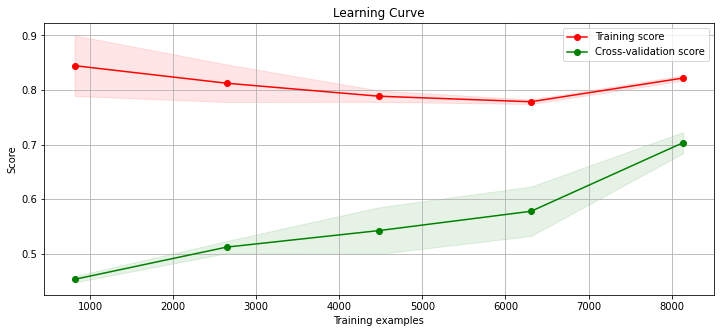

In [95]:
import scikitplot.estimators as esti
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))

rf = MultinomialNB()
esti.plot_learning_curve(rf, X_train,y_train, title='Learning Curve', 
                         cv=5, n_jobs=1, title_fontsize='large',text_fontsize='medium')
plt.show()

CV accuracy scores: [0.67583497 0.68369352 0.6719057  0.67976424 0.71807466 0.68633235
 0.72369715 0.72959685 0.72566372 0.73058014]
CV accuracy: 0.703 +/- 0.024


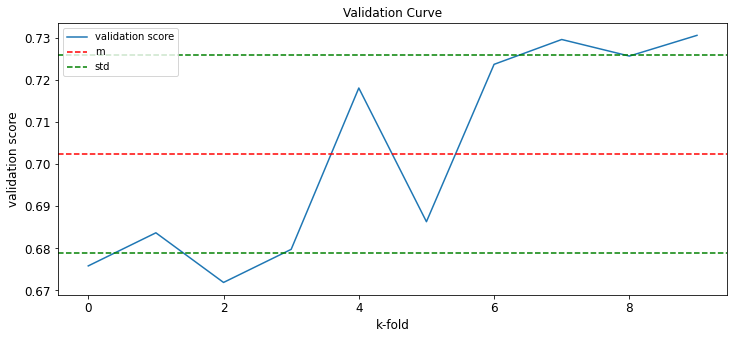

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

scores = cross_val_score(MultinomialNB(), X=X_train, y=y_train, cv=10)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))



plt.plot(scores, label='validation score')
plt.axhline(np.mean(scores),  label='m', color = 'r', linestyle='dashed')
plt.axhline(np.mean(scores)+ np.std(scores),  label='std', color = 'g', linestyle='dashed')
plt.axhline(np.mean(scores)- np.std(scores), color = 'g', linestyle='dashed')

plt.xlabel('k-fold')
plt.ylabel('validation score')
plt.title('Validation Curve')

plt.legend()

plt.show()

In [97]:
def learning_curve(clf, k):
    plt.figure(figsize=(5, 5))

    rf = clf
    esti.plot_learning_curve(rf, X_train,y_train, title='Learning Curve', 
                         cv=k, n_jobs=1, title_fontsize='large',text_fontsize='medium')
    plt.savefig('L_Curve'+str(clf)+'clf.png')
    plt.show()

Classification Model Performance Report
-TARGET-


**5-Fold-Cross-Validation**




/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/op

<Figure size 360x360 with 0 Axes>

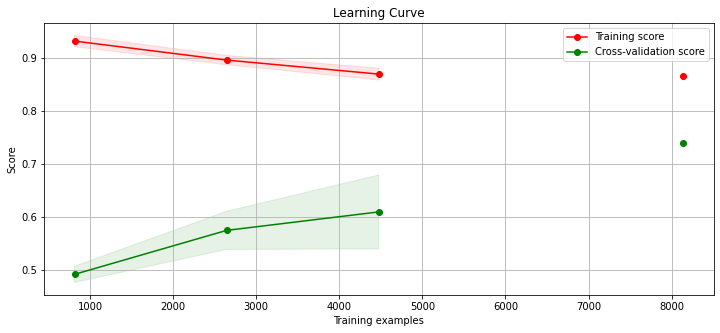

<Figure size 360x360 with 0 Axes>

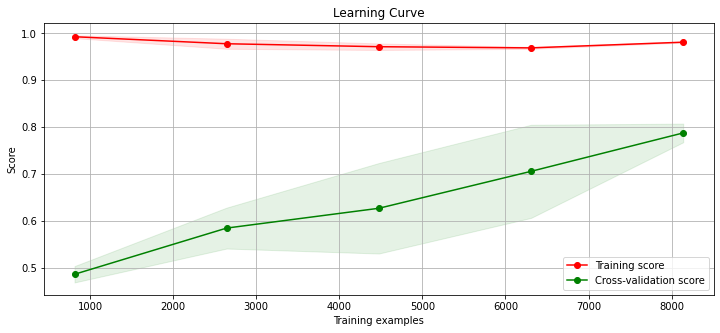

<Figure size 360x360 with 0 Axes>

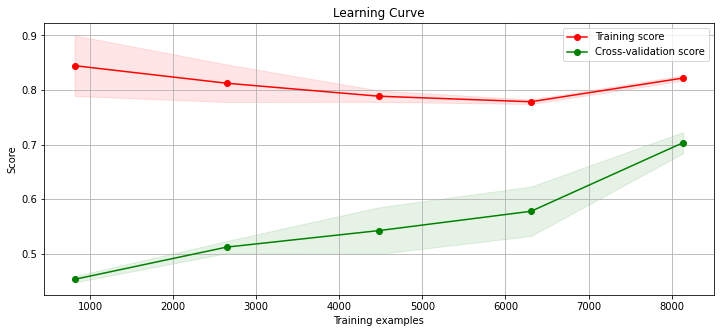

<Figure size 360x360 with 0 Axes>

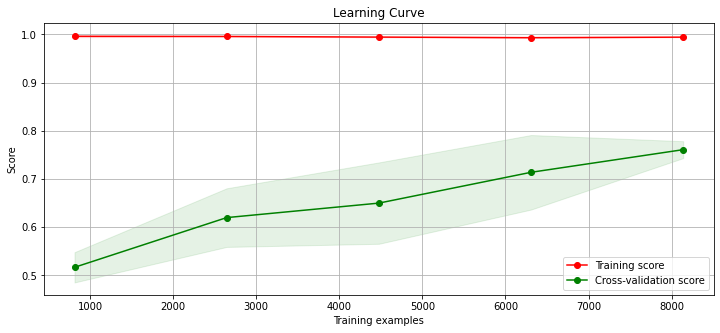

<Figure size 360x360 with 0 Axes>

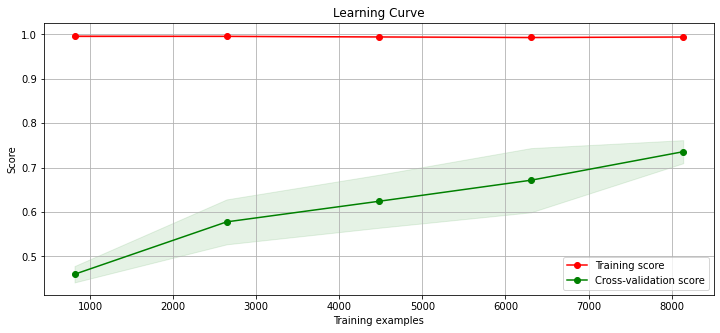

<Figure size 360x360 with 0 Axes>

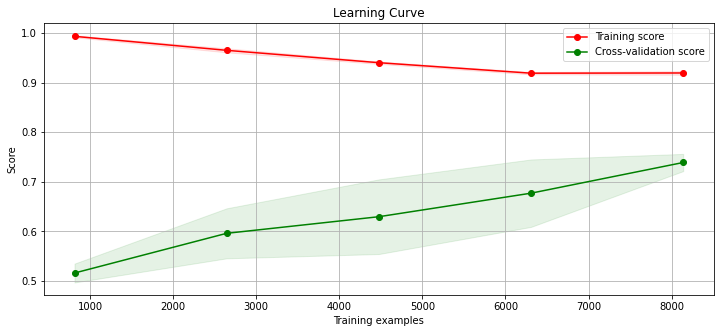

In [98]:
print('Classification Model Performance Report')
print('-TARGET-')
print('\n')
print('**5-Fold-Cross-Validation**')
print('\n')
learning_curve(LogisticRegression(), 5)
print('\n')

print('\n')
learning_curve(SVC(), 5)
print('\n')

print('\n')
learning_curve(MultinomialNB(), 5)
print('\n')

print('\n')
learning_curve(RandomForestClassifier(), 5)
print('\n')

print('\n')
learning_curve(DecisionTreeClassifier(), 5)
print('\n')

print('\n')
learning_curve(RidgeClassifier(), 5)
print('\n')

# Function call

In [99]:
def val_curve(clf, k):
    scores = cross_val_score(clf, X=X_train, y=y_train, cv=k)
    plt.plot(scores, label='validation score', marker='o')
    plt.axhline(np.mean(scores),  label='m', color = 'r', linestyle='dashed')
    plt.axhline(np.mean(scores)+ np.std(scores),  label='std', color = 'g', linestyle='dashed')
    plt.axhline(np.mean(scores)- np.std(scores), color = 'g', linestyle='dashed')

    plt.xlabel('k-fold')
    plt.ylabel('validation score')
    plt.title('Validation Curve')

    plt.legend()

    plt.show()
    print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Classification Model Performance Report
-Target-


**5-Fold-Cross-Validation**




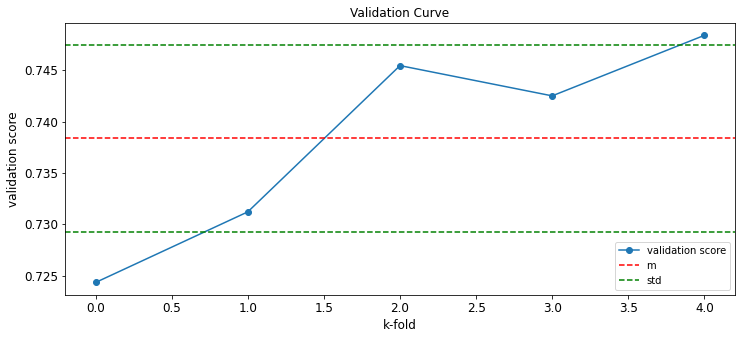

CV accuracy scores: [0.72432432 0.73120393 0.74545455 0.74250614 0.74840295]
CV accuracy: 0.738 +/- 0.009






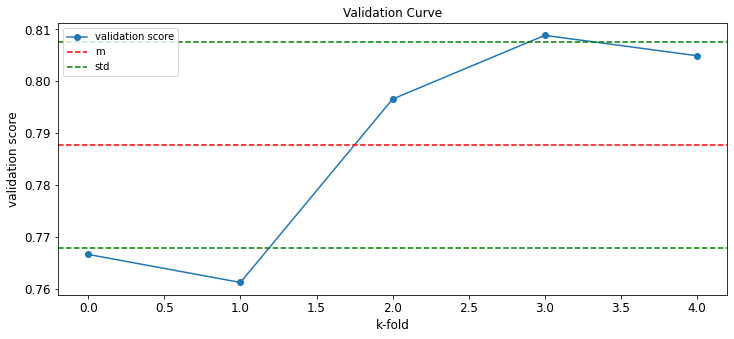

CV accuracy scores: [0.76658477 0.76117936 0.7965602  0.80884521 0.804914  ]
CV accuracy: 0.788 +/- 0.020






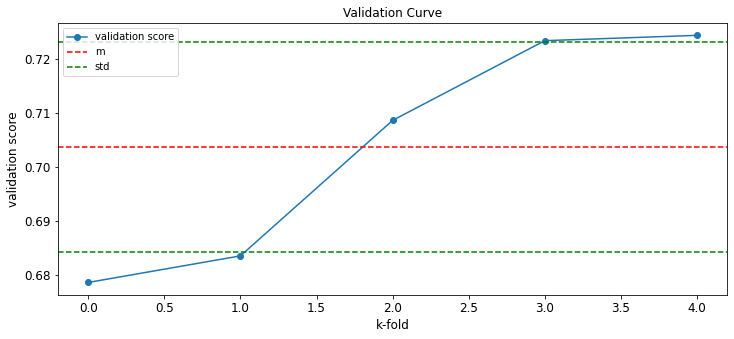

CV accuracy scores: [0.67862408 0.68353808 0.70859951 0.72334152 0.72432432]
CV accuracy: 0.704 +/- 0.019






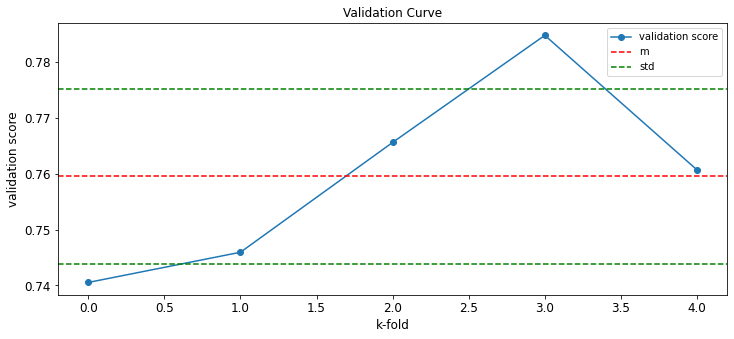

CV accuracy scores: [0.74054054 0.74594595 0.76560197 0.78476658 0.76068796]
CV accuracy: 0.760 +/- 0.016






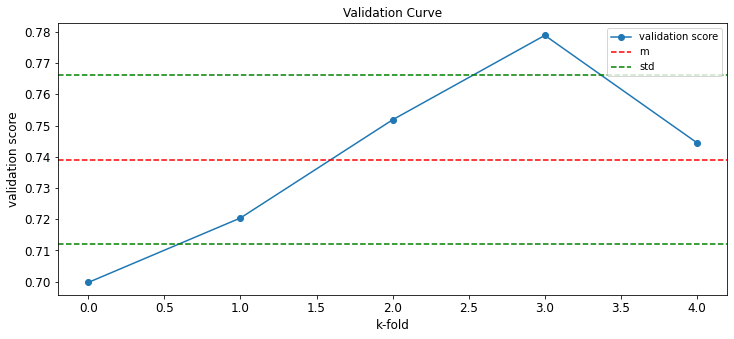

CV accuracy scores: [0.6997543  0.72039312 0.75184275 0.77886978 0.74447174]
CV accuracy: 0.739 +/- 0.027






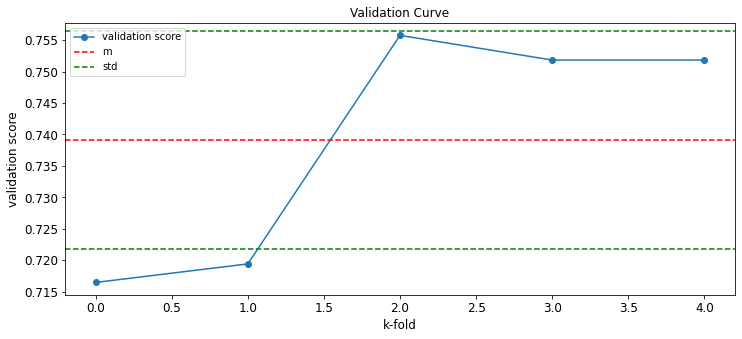

CV accuracy scores: [0.71646192 0.71941032 0.75577396 0.75184275 0.75184275]
CV accuracy: 0.739 +/- 0.017




In [100]:
print('Classification Model Performance Report')
print('-Target-')
print('\n')
print('**5-Fold-Cross-Validation**')
print('\n')
val_curve(LogisticRegression(), 5)
print('\n')

print('\n')
val_curve(SVC(), 5)
print('\n')

print('\n')
val_curve(MultinomialNB(), 5)
print('\n')

print('\n')
val_curve(RandomForestClassifier(), 5)
print('\n')

print('\n')
val_curve(DecisionTreeClassifier(), 5)
print('\n')

print('\n')
val_curve(RidgeClassifier(), 5)
print('\n')

# Gaussian Dist
Yellow Brick

Classification Report Testing set


              precision    recall  f1-score   support

       group       0.72      0.59      0.65       701
      person       0.76      0.70      0.73       922
      public       0.42      0.63      0.51       394

    accuracy                           0.65      2017
   macro avg       0.63      0.64      0.63      2017
weighted avg       0.68      0.65      0.66      2017

CV accuracy scores: [0.72432432 0.73120393 0.74545455 0.74250614 0.74840295]
CV accuracy: 0.738 +/- 0.009


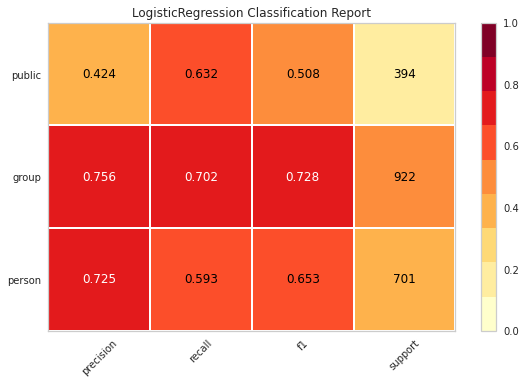

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [101]:
from sklearn.model_selection import cross_val_score

print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,LR_test_predictions))

scores = cross_val_score(LogisticRegression(), X=X_train, y=y_train, cv=5)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

from sklearn.model_selection import TimeSeriesSplit
from yellowbrick.classifier import ClassificationReport

# Load the classification dataset

# Specify the target classes
classes = ["person", "group", "public"]

# Instantiate the classification model and visualizer
model = LogisticRegression()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [102]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import TimeSeriesSplit
from yellowbrick.classifier import ClassificationReport

def print_report(clf):

    scores = cross_val_score(clf, X=X_train, y=y_train, cv=5)
    clf.fit(X_train,y_train)
    clf_test_predictions = clf.predict(X_test)
    print('Classification Report Testing set')
    print('\n')
    print(classification_report(y_test,clf_test_predictions))
    print('\n')
    print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
    
    # Specify the target classes
    classes = ["person", "group", "public"]

    # Instantiate the classification model and visualizer
    model = clf
    visualizer = ClassificationReport(model, classes=classes, support=True)

    visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and show the figure

Classification Report Testing set


              precision    recall  f1-score   support

       group       0.72      0.59      0.65       701
      person       0.76      0.70      0.73       922
      public       0.42      0.63      0.51       394

    accuracy                           0.65      2017
   macro avg       0.63      0.64      0.63      2017
weighted avg       0.68      0.65      0.66      2017



CV accuracy scores: [0.72432432 0.73120393 0.74545455 0.74250614 0.74840295]
CV accuracy: 0.738 +/- 0.009


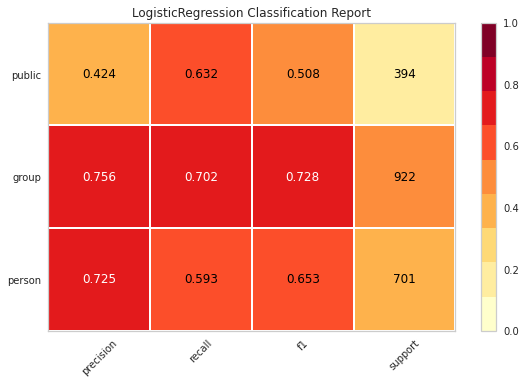



Classification Report Testing set


              precision    recall  f1-score   support

       group       0.70      0.61      0.65       701
      person       0.75      0.70      0.73       922
      public       0.44      0.61      0.51       394

    accuracy                           0.65      2017
   macro avg       0.63      0.64      0.63      2017
weighted avg       0.67      0.65      0.66      2017



CV accuracy scores: [0.72530713 0.72088452 0.74742015 0.74742015 0.74643735]
CV accuracy: 0.737 +/- 0.012


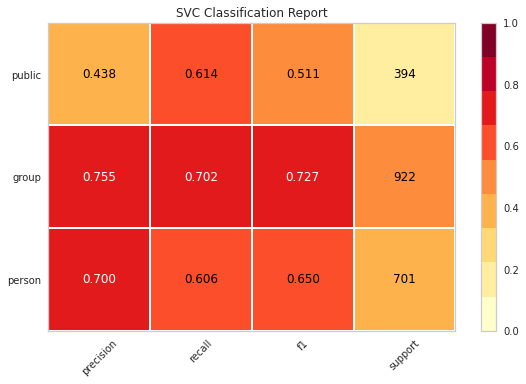



Classification Report Testing set


              precision    recall  f1-score   support

       group       0.73      0.57      0.64       701
      person       0.73      0.75      0.74       922
      public       0.40      0.54      0.46       394

    accuracy                           0.64      2017
   macro avg       0.62      0.62      0.61      2017
weighted avg       0.66      0.64      0.65      2017



CV accuracy scores: [0.67862408 0.68353808 0.70859951 0.72334152 0.72432432]
CV accuracy: 0.704 +/- 0.019


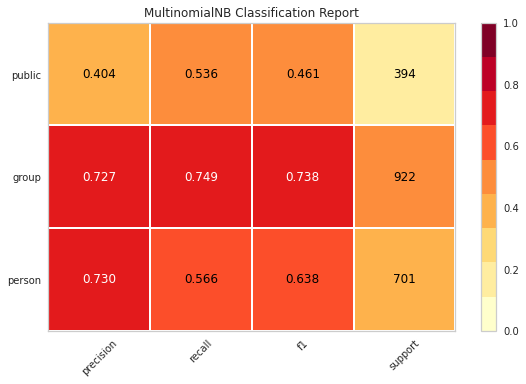



Classification Report Testing set


              precision    recall  f1-score   support

       group       0.71      0.62      0.66       701
      person       0.75      0.70      0.73       922
      public       0.45      0.62      0.52       394

    accuracy                           0.66      2017
   macro avg       0.64      0.65      0.64      2017
weighted avg       0.68      0.66      0.66      2017



CV accuracy scores: [0.73513514 0.74987715 0.77149877 0.78820639 0.75872236]
CV accuracy: 0.761 +/- 0.018


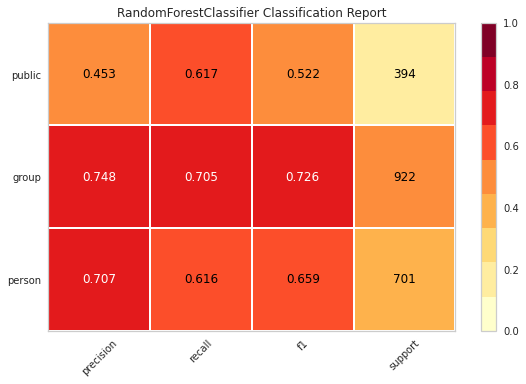



Classification Report Testing set


              precision    recall  f1-score   support

       group       0.59      0.56      0.58       701
      person       0.67      0.63      0.65       922
      public       0.40      0.50      0.45       394

    accuracy                           0.58      2017
   macro avg       0.56      0.56      0.56      2017
weighted avg       0.59      0.58      0.58      2017



CV accuracy scores: [0.6977887  0.70761671 0.76658477 0.77149877 0.75528256]
CV accuracy: 0.740 +/- 0.031


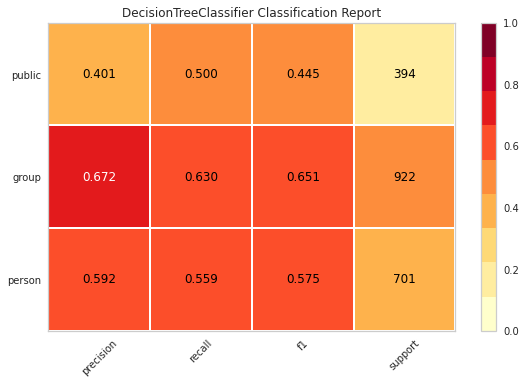



Classification Report Testing set


              precision    recall  f1-score   support

       group       0.69      0.60      0.64       701
      person       0.73      0.69      0.71       922
      public       0.42      0.57      0.48       394

    accuracy                           0.64      2017
   macro avg       0.61      0.62      0.61      2017
weighted avg       0.66      0.64      0.64      2017



CV accuracy scores: [0.71646192 0.71941032 0.75577396 0.75184275 0.75184275]
CV accuracy: 0.739 +/- 0.017


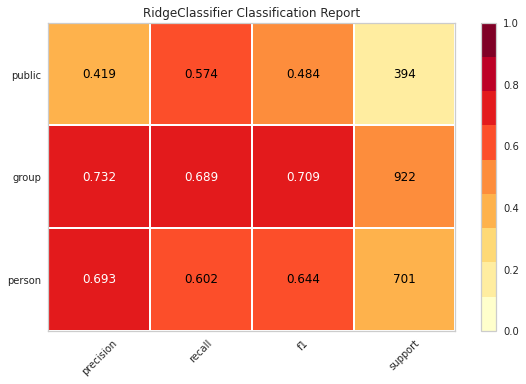

In [103]:
print_report(LogisticRegression())
print('\n')
print_report(SVC(kernel='linear'))
print('\n')
print_report(MultinomialNB())
print('\n')
print_report(RandomForestClassifier())
print('\n')
print_report(DecisionTreeClassifier())
print('\n')
print_report(RidgeClassifier())
print('\n')

# LABEL TEST SET AND EXPORT

In [104]:
testdaten = pd.read_csv('/kaggle/input/testdaten/Testdaten.tsv', sep='\t')
testdaten.head()

,c_id,c_text,date,author_id,like_count,quote_count,retweet_count,reply_count
0,1.384217e+18,@MichaelBroecker @HeuteBluhm @ArminLaschet @CD...,2021-04-19T18:46:54Z,1.109805e+18,1,0,0,0
1,1.397925e+18,@reitschuster Jetzt beginnt die Wahlwerbung fü...,2021-05-27T14:38:06Z,1.373293e+18,3,0,0,0
2,1.391853e+18,@welt Na wenn DA mal nicht ein paar Querdenker...,2021-05-10T20:30:49Z,1.217412e+18,0,0,0,0
3,1.383950e+18,@Eiterdaus Danke hatte ich schon. Is wie ne Gr...,2021-04-19T01:07:10Z,7.673723e+17,0,0,0,1
4,1.400755e+18,@janboehm Es gibt weitaus wichtigere Punkte um...,2021-06-04T10:04:10Z,1.252295e+18,1109,1,9,19


In [105]:
testdaten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   c_id           2034 non-null   float64
 1   c_text         2034 non-null   object 
 2   date           2034 non-null   object 
 3   author_id      2034 non-null   float64
 4   like_count     2034 non-null   int64  
 5   quote_count    2034 non-null   int64  
 6   retweet_count  2034 non-null   int64  
 7   reply_count    2034 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 127.2+ KB


In [106]:
def clf_predict(text):
    
    input_text=[]
    input_text = [text]
    
    #TFIDF
    X_TEST = vectorizer.transform(input_text)
    
    #Prediction
    classification_score = rfclassifier.predict(X_TEST)
    classification_score = str(classification_score)
        
    return classification_score

In [107]:
print(clf_predict(testdaten['c_text'][3]))
print(testdaten['c_text'][3])

['person']
@Eiterdaus Danke hatte ich schon. Is wie ne Grippe, also nicht ängstlich. Is nur für alte und kranke wirklich gefährlich. Ja das zeigt was du für ein intoleranter, verborter Mensch bist der den Mainstream Müll aus den Medien nachplappert!!! Hauptsache man kann nazi schreiben


In [108]:
from tqdm import tqdm
tqdm.pandas()


testdaten['target'] = testdaten['c_text'].progress_apply(lambda n : clf_predict(n))
testdaten.head(10)

100%|██████████| 2034/2034 [00:22<00:00, 90.87it/s]


,c_id,c_text,date,author_id,like_count,quote_count,retweet_count,reply_count,target
0,1.384217e+18,@MichaelBroecker @HeuteBluhm @ArminLaschet @CD...,2021-04-19T18:46:54Z,1.109805e+18,1,0,0,0,['person']
1,1.397925e+18,@reitschuster Jetzt beginnt die Wahlwerbung fü...,2021-05-27T14:38:06Z,1.373293e+18,3,0,0,0,['group']
2,1.391853e+18,@welt Na wenn DA mal nicht ein paar Querdenker...,2021-05-10T20:30:49Z,1.217412e+18,0,0,0,0,['group']
3,1.383950e+18,@Eiterdaus Danke hatte ich schon. Is wie ne Gr...,2021-04-19T01:07:10Z,7.673723e+17,0,0,0,1,['person']
4,1.400755e+18,@janboehm Es gibt weitaus wichtigere Punkte um...,2021-06-04T10:04:10Z,1.252295e+18,1109,1,9,19,['public']
5,1.388448e+18,@amo_il_caffe @Dr_Emergencydoc Vor Monaten sch...,2021-05-01T10:59:54Z,7.411392e+17,0,0,0,0,['public']
6,1.384275e+18,@noaheIeazar @arouet71 @tagesthemen @tagesscha...,2021-04-19T22:38:03Z,1.238851e+18,1,0,0,2,['group']
7,1.387171e+18,"https://t.co/AykzTbk6Gc #E0105\n9.30 Uhr, Froh...",2021-04-27T22:26:06Z,4.770650e+07,0,1,0,0,['group']
8,1.400062e+18,@herr_sin @Karl_Lauterbach @Alice_Weidel Perso...,2021-06-02T12:09:39Z,8.380310e+17,1,0,0,0,['public']
9,1.389253e+18,Cn Naziterror\n\nDu läufst mit paar linken Pat...,2021-05-03T16:18:36Z,9.706050e+17,1,0,0,1,['person']


In [109]:
testdaten['target'].value_counts()

['person']    966
['group']     581
['public']    487
Name: target, dtype: int64

In [110]:
testdaten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   c_id           2034 non-null   float64
 1   c_text         2034 non-null   object 
 2   date           2034 non-null   object 
 3   author_id      2034 non-null   float64
 4   like_count     2034 non-null   int64  
 5   quote_count    2034 non-null   int64  
 6   retweet_count  2034 non-null   int64  
 7   reply_count    2034 non-null   int64  
 8   target         2034 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 143.1+ KB


In [111]:
testdaten = testdaten.drop('c_text', axis=1)
testdaten = testdaten.drop('date', axis=1)
testdaten = testdaten.drop('author_id', axis=1)
testdaten = testdaten.drop('like_count', axis=1)
testdaten = testdaten.drop('quote_count', axis=1)
testdaten = testdaten.drop('retweet_count', axis=1)
testdaten = testdaten.drop('reply_count', axis=1)

In [112]:
testdaten['c_id'] = testdaten['c_id'].progress_apply(lambda n: int(n))
testdaten.head()

100%|██████████| 2034/2034 [00:00<00:00, 438510.12it/s]


,c_id,target
0,1384216954488049664,['person']
1,1397925083717410816,['group']
2,1391853254615699712,['group']
3,1383950264403587072,['person']
4,1400755246411005952,['public']


In [113]:
compression_opts = dict(method='zip',archive_name='Target_Gruppe4_1b.csv')  
testdaten.to_csv('Target_Gruppe4_1b.zip', index=False, compression=compression_opts)  

# Model Comparison

In [114]:
def cv_score(clf,k):
    score = cross_val_score(clf, X=X_train, y=y_train, cv=k)
    return score

In [115]:
results = {'Classifier Name':  ['LogisticRegression', 'MultinomialNB', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'RidgeClassifier'],
        'acc_train':  [ accuracy_score(y_train,LR_train_predictions), accuracy_score(y_train,NB_train_predictions), accuracy_score(y_train,SVM_train_predictions), accuracy_score(y_train,DT_train_predictions), accuracy_score(y_train,RF_train_predictions), accuracy_score(y_train,RC_train_predictions)],
        'acc_test':  [ accuracy_score(y_test,LR_test_predictions), accuracy_score(y_test,NB_test_predictions), accuracy_score(y_test,SVM_test_predictions), accuracy_score(y_test,DT_test_predictions), accuracy_score(y_test,RF_test_predictions), accuracy_score(y_test,RC_test_predictions)],
        'mean_cv_score(5)':  [np.mean(cv_score(LogisticRegression(),5)), np.mean(cv_score(MultinomialNB(),5)), np.mean(cv_score(SVC(),5)), np.mean(cv_score(DecisionTreeClassifier(),5)), np.mean(cv_score(RandomForestClassifier(),5)),np.mean(cv_score(RidgeClassifier(),5))],
        'std_cv_score(5)':  [np.std(cv_score(LogisticRegression(),5)), np.std(cv_score(MultinomialNB(),5)), np.std(cv_score(SVC(),5)), np.std(cv_score(DecisionTreeClassifier(),5)), np.std(cv_score(RandomForestClassifier(),5)),np.std(cv_score(RidgeClassifier(),5))]}

results = pd.DataFrame(results)

results.head(6)

,Classifier Name,acc_train,acc_test,mean_cv_score(5),std_cv_score(5)
0,LogisticRegression,0.857101,0.650471,0.738378,0.009128
1,MultinomialNB,0.810319,0.644026,0.703686,0.019341
2,SVC,0.878428,0.651463,0.787617,0.019855
3,DecisionTreeClassifier,0.994201,0.585027,0.736904,0.026467
4,RandomForestClassifier,0.994201,0.642043,0.761081,0.016830
5,RidgeClassifier,0.907617,0.636093,0.739066,0.017337


In [116]:
compression_opts = dict(method='zip',archive_name='results_of_classification.csv')  
results.to_csv('TC_results.zip', index=False, compression=compression_opts) 